In [32]:
# get max test id so far
import os
test_ids = [int(f.split("_")[1].split(".")[0]) for f in os.listdir("parsed_tests") if f.startswith("test_")]

max_test_id = max(test_ids)
max_test_id

967747

Původní počet otázek: 13484
Počet otázek za 3 body: 2334
------------------------------
Nalezeno 1 měsíců s daty (za 3 body). Ukládám všechny grafy...
------------------------------


/tmp/ipykernel_53386/3086730387.py:32: DeprecationWarning:

`pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)



Histogram pro měsíc September 2025 (3 body) byl uložen do souboru: histogram_month_3_points/top50_questions_2025-09.png

--- Zobrazuji nejnovější graf (3 body) ---


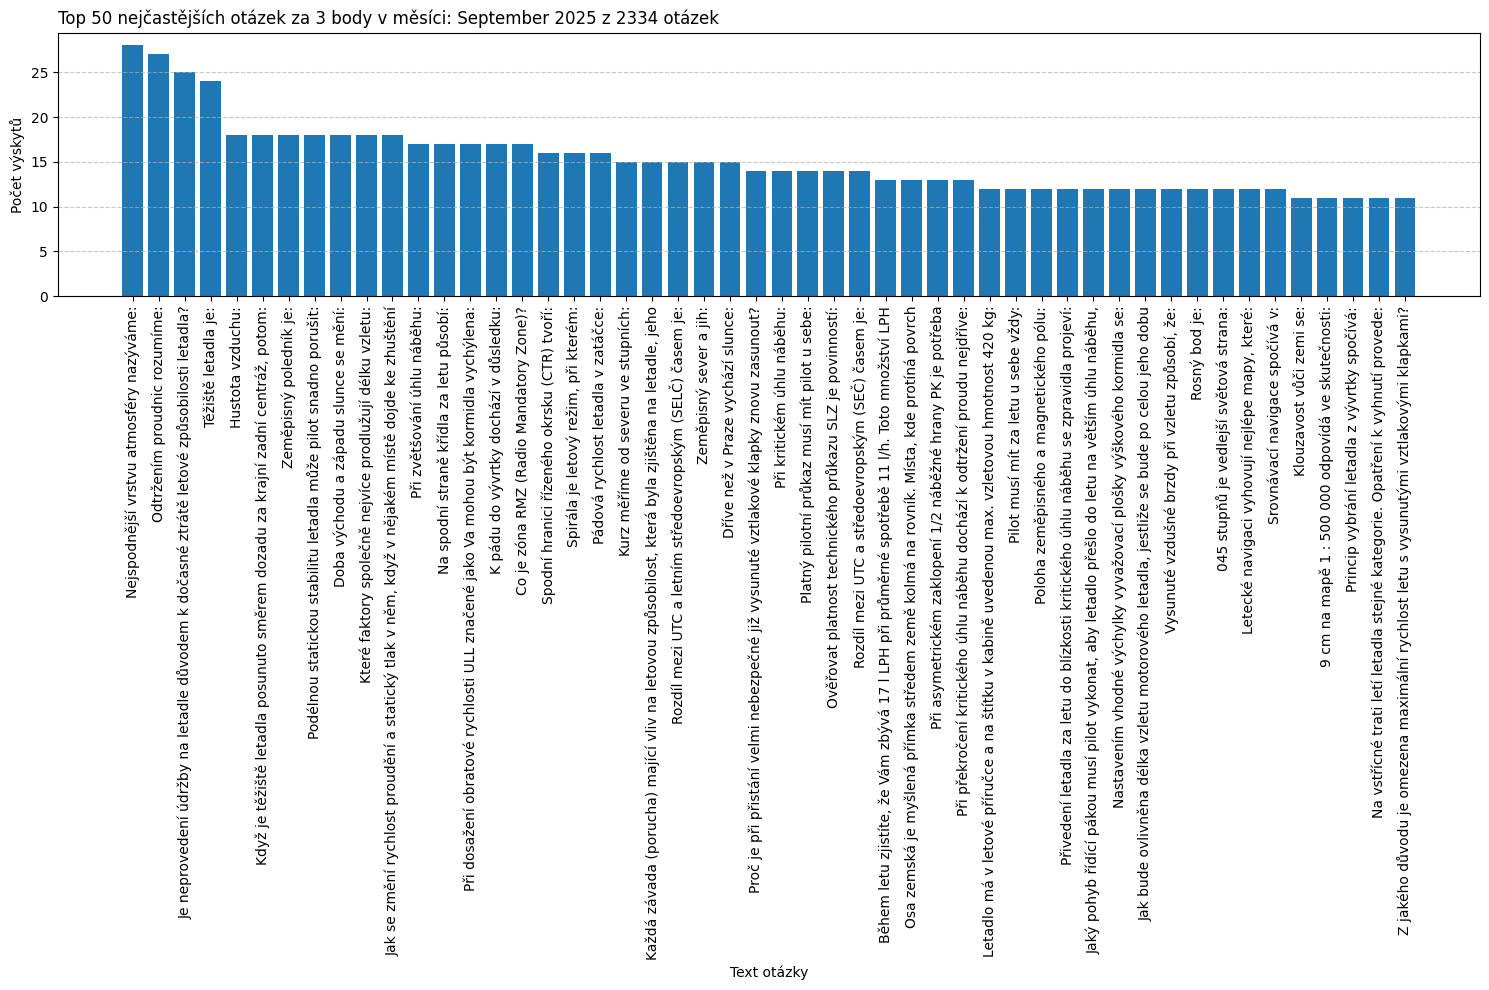

------------------------------
Proměnná 'EXPORT_newest_histogram_month' obsahuje cestu k nejnovějšímu souboru:
histogram_month_3_points/top50_questions_2025-09.png


In [34]:
import polars as pl
import matplotlib.pyplot as plt
import warnings
from datetime import timedelta
import os

# Potlačení varování, které může Polars vyvolat při agregacích s datovými typy
warnings.simplefilter(action='ignore', category=FutureWarning)

# Inicializace proměnné pro export
EXPORT_newest_histogram_month = None

# Zkontrolujeme, zda původní DataFrame 'df' existuje
if 'df' in locals() and df is not None and len(df) > 0:

    # --- KLÍČOVÁ ZMĚNA: Filtrace otázek pouze za 3 body ---
    print(f"Původní počet otázek: {len(df)}")
    df_3_points = df.filter(pl.col("body") == 3)
    print(f"Počet otázek za 3 body: {len(df_3_points)}")
    print("-" * 30)
    # ---------------------------------------------------------

    # Zkontrolujeme, zda po filtraci nějaké otázky zbyly
    if not df_3_points.is_empty():
        # 1. KROK: Přidání sloupce s měsícem (již k filtrovaným datům)
        df_with_month = df_3_points.with_columns(
            pl.col("datum_testu").dt.truncate("1mo").alias("mesic")
        )

        # 2. KROK: Seskupení otázek podle měsíce a textu
        monthly_counts = df_with_month.group_by("mesic", "text_otazky").agg(
            pl.count().alias("pocet_vyskytu")
        ).sort("mesic", "pocet_vyskytu", descending=[False, True])

        # 3. KROK: Získání unikátních měsíců a identifikace toho nejnovějšího
        unique_months = monthly_counts.get_column("mesic").unique().sort()

        if not unique_months.is_empty():
            newest_month_date = unique_months[-1]

            # --- Příprava na export ---
            # Vytvoříme novou složku pro tyto specifické grafy
            output_directory = 'histogram_month_3_points'
            os.makedirs(output_directory, exist_ok=True)

            newest_month_filename_str = newest_month_date.strftime('%Y-%m')
            EXPORT_newest_histogram_month = f"{output_directory}/top50_questions_{newest_month_filename_str}.png"

            print(f"Nalezeno {len(unique_months)} měsíců s daty (za 3 body). Ukládám všechny grafy...")
            print("-" * 30)

            # 4. KROK: Iterace přes VŠECHNY měsíce
            for month_start_date in unique_months:
                top_questions_in_month = monthly_counts.filter(
                    pl.col("mesic") == month_start_date
                ).head(50)

                month_title_str = month_start_date.strftime('%B %Y')
                month_filename_str = month_start_date.strftime('%Y-%m')
                current_filename = f"{output_directory}/top50_questions_{month_filename_str}.png"

                # --- Vykreslení grafu ---
                plt.figure(figsize=(15, 10))

                plt.bar(
                    top_questions_in_month.get_column("text_otazky"),
                    top_questions_in_month.get_column("pocet_vyskytu")
                )

                plt.xlabel("Text otázky")
                plt.ylabel("Počet výskytů")
                plt.xticks(rotation=90)

                total_questions_in_month = df_with_month.filter(pl.col('mesic') == month_start_date).height

                # --- ÚPRAVA TITULKU ---
                plt.title(f"Top {len(top_questions_in_month)} nejčastějších otázek za 3 body v měsíci: {month_title_str} z {total_questions_in_month} otázek", loc='left')

                plt.grid(axis='y', linestyle='--', alpha=0.7)
                plt.tight_layout()

                plt.savefig(current_filename)
                print(f"Histogram pro měsíc {month_title_str} (3 body) byl uložen do souboru: {current_filename}")

                if month_start_date == newest_month_date:
                    print("\n--- Zobrazuji nejnovější graf (3 body) ---")
                    plt.show()

                plt.close()
        else:
            print("Pro otázky za 3 body nebyla nalezena žádná data k zobrazení.")
    else:
        print("Nebyly nalezeny žádné otázky s hodnotou 3 body.")
else:
    print("DataFrame 'df' neexistuje nebo je prázdný. Nejprve spusťte buňku pro načtení dat.")

# Na konci vypíšeme obsah proměnné pro kontrolu
print("-" * 30)
if EXPORT_newest_histogram_month:
    print(f"Proměnná 'EXPORT_newest_histogram_month' obsahuje cestu k nejnovějšímu souboru:")
    print(EXPORT_newest_histogram_month)
else:
    print("Proměnná 'EXPORT_newest_histogram_month' je prázdná, protože nebyl vygenerován žádný graf.")

In [33]:
# Krok 1: Instalace potřebných knihoven
# Odkomentujte a spusťte následující řádek, pokud knihovny ještě nemáte nainstalované
# !pip install requests pdfplumber

import requests
import io
import pdfplumber
import re
import json
import os
from pprint import pprint

def analyzuj_test_z_pdf(url: str):
    """
    Stáhne PDF test z dané URL, vyparsuje z něj otázky a odpovědi
    a vrátí strukturovaná data.
    """
    print(f"Stahuji PDF z adresy: {url}...")

    try:
        # Stažení PDF souboru
        response = requests.get(url, timeout=30)
        response.raise_for_status()
        print("PDF úspěšně staženo.")

        pdf_content = response.content

        # Extrakce textu z PDF
        print("Parsuji obsah PDF...")
        full_text = ""
        with io.BytesIO(pdf_content) as pdf_stream:
            with pdfplumber.open(pdf_stream) as pdf:
                for page in pdf.pages:
                    full_text += page.extract_text() + "\n"

        print("Extrakce textu dokončena. Zpracovávám otázky...")

        # Zpracování textu
        pattern_otazky = re.compile(r'(\d+)\.\s+([\s\S]+?)(?=Počet bodů: (\d))', re.MULTILINE)
        otazky = []
        matches = pattern_otazky.finditer(full_text)

        for match in matches:
            cislo_otazky = int(match.group(1))
            blok_otazky = match.group(2).strip()
            radky = blok_otazky.split('\n')
            text_otazky = radky[0]
            body_otazky = int(match.group(3))

            moznosti = {}
            spravna_odpoved = None

            # Regulární výraz pro odpovědi
            pattern_odpovedi = re.compile(r'^\s*([A-C])\.\s*(.*?)\s*$')

            for radek in radky[1:]:
                match_odpovedi = pattern_odpovedi.match(radek)
                if match_odpovedi:
                    pismeno = match_odpovedi.group(1)
                    zbytek_radku = match_odpovedi.group(2)

                    # Kontrola správné odpovědi (smajlík ☻)
                    if '☺' in zbytek_radku or '☻' in zbytek_radku:
                        spravna_odpoved = pismeno


                    # Vyčištění textu odpovědi od speciálních znaků
                    text_odpovedi = re.sub(r'[x☺☻●]', '', zbytek_radku).strip()
                    moznosti[pismeno] = text_odpovedi

            # Přidání pouze požadovaných dat
            otazky.append({
                "text_otazky": text_otazky,
                "moznosti": moznosti,
                "spravna_odpoved": spravna_odpoved,
                "body": body_otazky
            })

        print("Zpracování dokončeno.")
        return {
            "datum_testu": re.search(r'Datum ([\d.]+)', full_text).group(1),

            "prehled_otazek": otazky,
        }

    except requests.exceptions.RequestException as e:
        print(f"Chyba při stahování PDF: {e}")
        return None
    except Exception as e:
        print(f"Nastala neočekávaná chyba: {e}")
        return None



url_base = "https://zkouseni.laacr.cz/Zkouseni/PDFReport?module=M09&report=vysledek&id="

chyba_count = 0
for i in range(max_test_id, max_test_id+100):
    url_pdf_testu = url_base + str(i)

    # check if the if the test with this id exists in folder "parsed_tests"
    if f"test_{i}.json" in os.listdir("parsed_tests"):
        print("Skipuji zpracování, test již existuje.")
        continue
    print(f"\n\n--- Zpracovávám test s ID {i} ---")
    zpracovana_data = analyzuj_test_z_pdf(url_pdf_testu)
    if zpracovana_data is None:
        print(f"Test s ID {i} neexistuje nebo nastala chyba.")
        chyba_count += 1
        if chyba_count >= 5:
            print("Počet po sobě jdoucích chyb dosáhl 5, ukončuji zpracování.")
            break
        continue
    json.dump(zpracovana_data, open(f"parsed_tests/test_{i}.json", "w"), ensure_ascii=False, indent=4)



Skipuji zpracování, test již existuje.


--- Zpracovávám test s ID 967748 ---
Stahuji PDF z adresy: https://zkouseni.laacr.cz/Zkouseni/PDFReport?module=M09&report=vysledek&id=967748...
PDF úspěšně staženo.
Parsuji obsah PDF...
Extrakce textu dokončena. Zpracovávám otázky...
Zpracování dokončeno.


--- Zpracovávám test s ID 967749 ---
Stahuji PDF z adresy: https://zkouseni.laacr.cz/Zkouseni/PDFReport?module=M09&report=vysledek&id=967749...
PDF úspěšně staženo.
Parsuji obsah PDF...
Extrakce textu dokončena. Zpracovávám otázky...
Zpracování dokončeno.


--- Zpracovávám test s ID 967750 ---
Stahuji PDF z adresy: https://zkouseni.laacr.cz/Zkouseni/PDFReport?module=M09&report=vysledek&id=967750...
PDF úspěšně staženo.
Parsuji obsah PDF...
Extrakce textu dokončena. Zpracovávám otázky...
Zpracování dokončeno.


--- Zpracovávám test s ID 967751 ---
Stahuji PDF z adresy: https://zkouseni.laacr.cz/Zkouseni/PDFReport?module=M09&report=vysledek&id=967751...
PDF úspěšně staženo.
Parsuji obsah PDF...